In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('dataR2.csv')
df.head()

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,1
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,1
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,1
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220,1
4,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920,1


In [3]:
df.shape

(116, 10)

In [4]:
X = df.iloc[:, :-1] # features
y = df['Classification'] # classes

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [6]:
# select the most informative features

selector = SelectKBest(score_func=mutual_info_classif, k=5)
selector.fit(X_train, y_train)
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)

mask = selector.get_support(indices=True)
X.columns[mask]

Index(['Age', 'Glucose', 'HOMA', 'Leptin', 'Resistin'], dtype='object')

In [7]:
# data normalization

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# baseline classifications

etc = ExtraTreesClassifier(random_state=10)
rfc = RandomForestClassifier(random_state=10)
abc = AdaBoostClassifier(random_state=10)
gbc = GradientBoostingClassifier(random_state=10)
gnb = GaussianNB()

clfs = {etc, rfc, abc, gbc, gnb}

for clf in clfs:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf, "accuracy {:.2f}%".format(accuracy_score(y_test, y_pred)*100))

GradientBoostingClassifier(random_state=10) accuracy 87.50%
ExtraTreesClassifier(random_state=10) accuracy 83.33%
AdaBoostClassifier(random_state=10) accuracy 87.50%
GaussianNB() accuracy 83.33%
RandomForestClassifier(random_state=10) accuracy 79.17%


In [9]:
# randomized search CV

etc_params = {'n_estimators': [10, 50, 100, 200, 300, 500],
              'criterion': ['gini', 'entropy', 'log_loss'],
              'min_samples_split': [2, 3, 4, 5],
              'min_samples_leaf': [1, 2, 3, 4, 5],
              'max_features': ['sqrt', 'log2', None]}

rfc_params = {'n_estimators':[10, 50, 100, 200, 300, 500],
              'criterion': ['gini', 'entropy', 'log_loss'],
              'min_samples_split': [2, 3, 4, 5],
              'min_samples_leaf': [1, 2, 3, 4, 5],
              'max_features': ['sqrt', 'log2', None]}

abc_params = {'estimator': [DecisionTreeClassifier(), RandomForestClassifier(), ExtraTreesClassifier()],
              'n_estimators': [10, 50, 100, 200, 300, 500],
              'learning_rate': [0.1, 0.5, 1, 2, 5, 10],
              'algorithm': ['SAMME', 'SAMME.R']}

gbc_params = {'loss': ['log_loss', 'exponential'],
              'learning_rate': [0.1, 0.5, 1, 2, 5, 10],
              'n_estimators': [10, 50, 100, 200, 300, 500],
              'subsample': [0.1, 0.2, 0.5, 0.8, 1],
              'criterion': ['friedman_mse', 'squared_error'],
              'min_samples_split': [2, 3, 4, 5],
              'min_samples_leaf': [1, 2, 3, 4, 5],
              'max_depth': [1, 2, 3, 5, None]}

gnb_params = {'var_smoothing': [1e-8, 1e-9, 1e-10]}


etc_model = RandomizedSearchCV(etc, etc_params, n_iter=100, random_state=10)           
etc_model.fit(X_train, y_train)    

rfc_model = RandomizedSearchCV(rfc, rfc_params, n_iter=100, random_state=10)           
rfc_model.fit(X_train, y_train)    

abc_model = RandomizedSearchCV(abc, abc_params, n_iter=100, random_state=10)           
abc_model.fit(X_train, y_train)      

gbc_model = RandomizedSearchCV(gbc, gbc_params, n_iter=100, random_state=10)           
gbc_model.fit(X_train, y_train)     

gnb_model = RandomizedSearchCV(gnb, gnb_params, n_iter=3, random_state=10)           
gnb_model.fit(X_train, y_train)  

models = {('ExtraTrees', etc_model), ('RandomForest', rfc_model), ('AdaBoost', abc_model), ('GradientBoost', gbc_model), ('GaussianNB', gnb_model)}

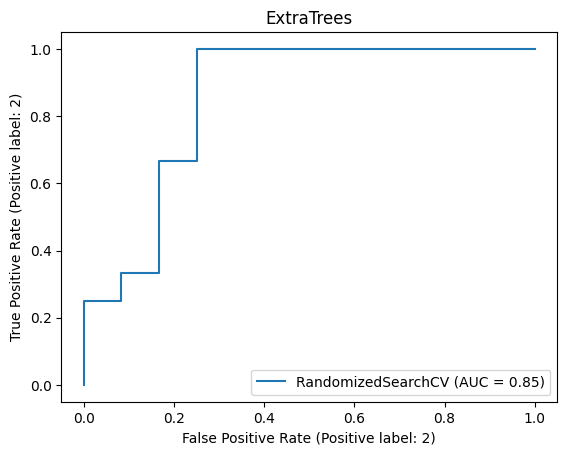

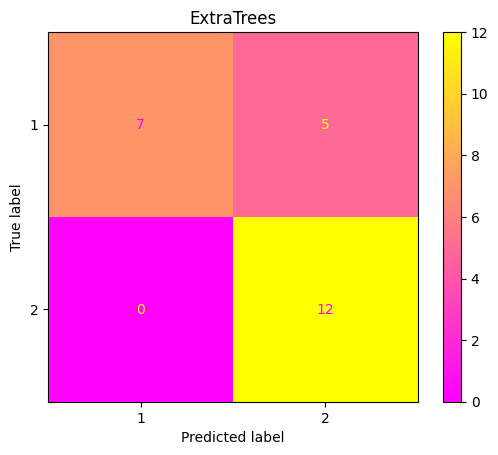

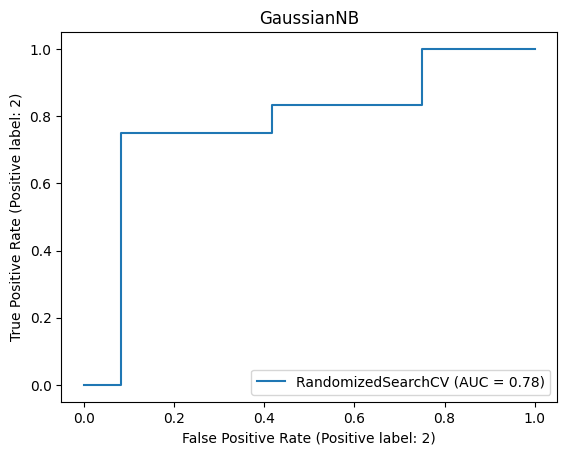

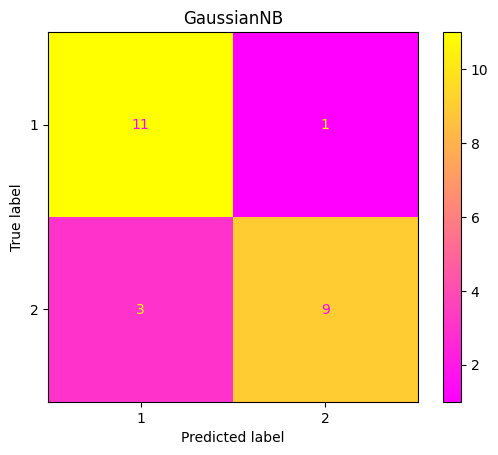

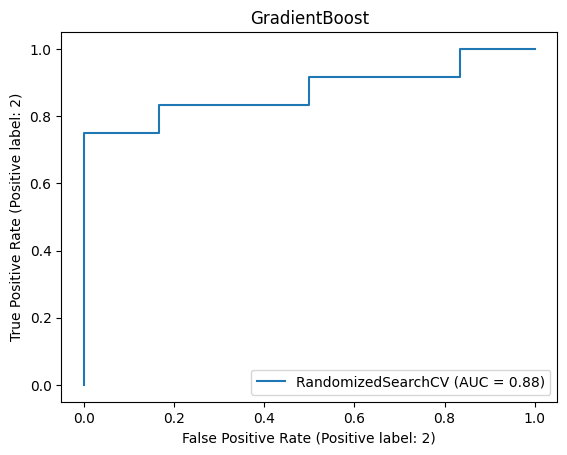

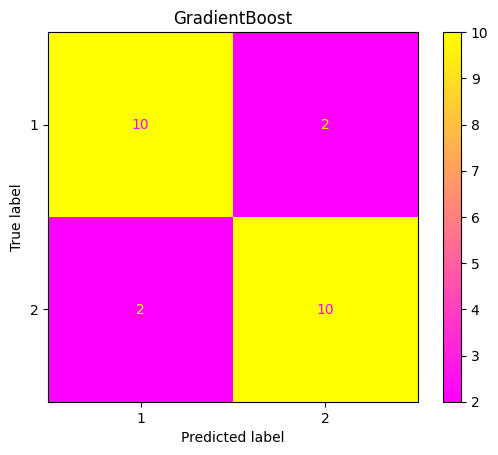

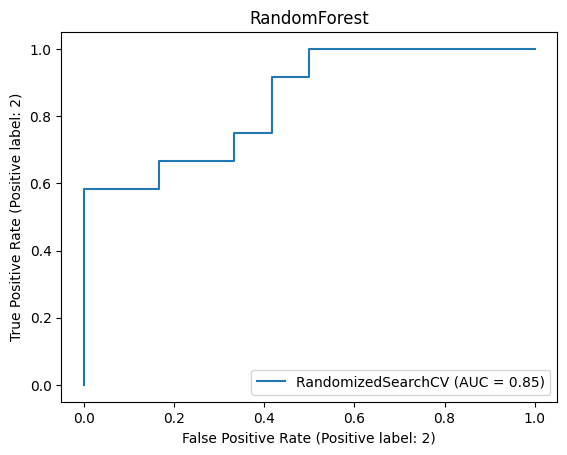

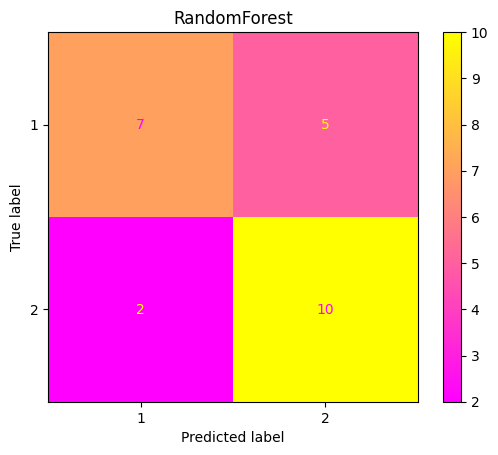

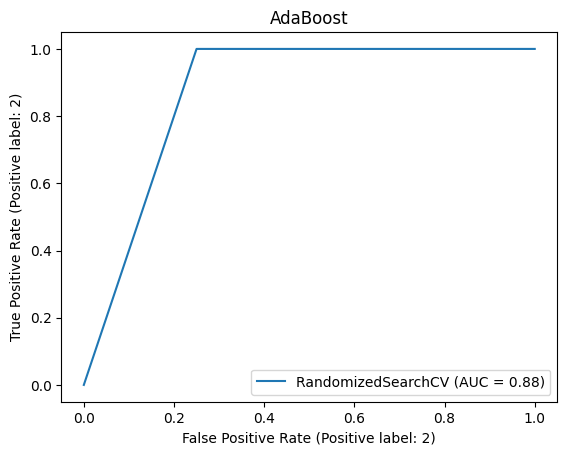

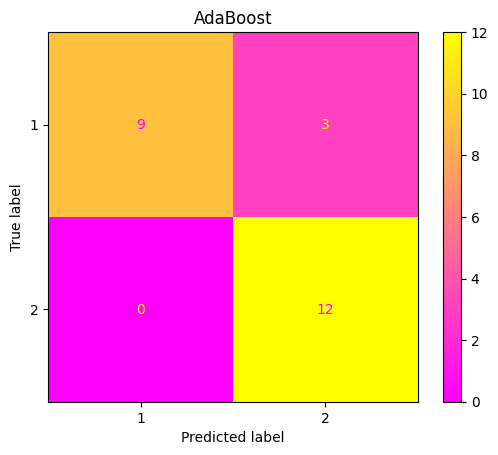

In [10]:
# evaluation

feature_importances = pd.DataFrame(columns=list(X.columns[mask]))
scores = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC'])

for model_name, model in models:
    
    if model_name != 'GaussianNB':
        feature_importances.loc[model_name] = model.best_estimator_.feature_importances_
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    scores.loc[model_name] = [accuracy_score(y_test, y_pred),
                              precision_score(y_test, y_pred, pos_label=2),
                              recall_score(y_test, y_pred, pos_label=2),
                              f1_score(y_test, y_pred, pos_label=2),
                              roc_auc_score(y_test, y_proba[:, 1])]

    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(model_name)
    plt.show()

    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='spring')
    plt.title(model_name)
    plt.show()

In [11]:
# scores

display(feature_importances) 

display(scores)

,Age,Glucose,HOMA,Leptin,Resistin
ExtraTrees,0.248132,0.356853,0.153791,8.411286e-02,1.571105e-01
GradientBoost,0.976856,0.000001,0.023142,2.491870e-08,1.998122e-11
RandomForest,0.180649,0.402780,0.229658,5.730873e-02,1.296035e-01
AdaBoost,0.219331,0.264791,0.173912,1.604836e-01,1.814826e-01


,Accuracy,Precision,Recall,F1,ROC_AUC
ExtraTrees,0.791667,0.705882,1.000000,0.827586,0.854167
GaussianNB,0.833333,0.900000,0.750000,0.818182,0.777778
GradientBoost,0.833333,0.833333,0.833333,0.833333,0.875000
RandomForest,0.708333,0.666667,0.833333,0.740741,0.847222
AdaBoost,0.875000,0.800000,1.000000,0.888889,0.875000
